# Análisis y reporte de complejidad ciclomática

## 📐 ¿Qué es la Complejidad Ciclomática?

La **complejidad ciclomática** es una métrica que mide la complejidad lógica de un programa.  
Fue introducida por Thomas J. McCabe en 1976 y ayuda a estimar:

- Cuántos caminos de ejecución independientes existen.
- Cuántas pruebas unitarias mínimas se necesitan para cubrir todas las rutas.
- Dónde puede aumentar el riesgo de errores de mantenimiento.

### 🧮 **Fórmula**

En términos de teoría de grafos, se define como:

\\[
M = E - N + 2P
\\]

Donde:  
- \\( M \\) es la complejidad ciclomática  
- \\( E \\) es el número de aristas del grafo de flujo de control  
- \\( N \\) es el número de nodos  
- \\( P \\) es el número de componentes conexos (normalmente 1 para una función o método)

### ✅ **Interpretación práctica**

- Un valor de **1** implica que la función es lineal, sin bifurcaciones.
- Cada `if`, `case`, `for`, `while` o `catch` incrementa la complejidad.
- Valores altos indican riesgo de código difícil de testear y mantener.

**Regla de pulgar:**  
Mantener la complejidad ciclomática por debajo de **10** suele ser una buena práctica,  
aunque el umbral realista varía según estilo, lenguaje y contexto.

### 📚 **Referencia**

> *McCabe, T. J. (1976). A Complexity Measure. IEEE Transactions on Software Engineering, SE-2(4), 308–320.*


In [3]:
import pandas as pd
df = pd.read_csv("../results/metrics.csv",    names=[
        "nloc",
        "cyclomatic_complexity",
        "token_count",
        "parameters",
        "length",
        "function_info",
        "filename",
        "name",
        "long_name",
        "start_line",
        "end_line"])
df.head()

,nloc,cyclomatic_complexity,token_count,parameters,length,function_info,filename,name,long_name,start_line,end_line
0,1,1,10,0,1,Worker::Worker@13-13@../../../apps/calcjob/Wor...,../../../apps/calcjob/Worker.hpp,Worker::Worker,Worker::Worker(),13,13
1,3,1,26,0,3,Worker::start@15-17@../../../apps/calcjob/Work...,../../../apps/calcjob/Worker.hpp,Worker::start,Worker::start(),15,17
2,8,1,31,0,8,Worker::stopWorker@19-26@../../../apps/calcjob...,../../../apps/calcjob/Worker.hpp,Worker::stopWorker,Worker::stopWorker(),19,26
3,5,1,30,1,5,Worker::enqueueJob@28-32@../../../apps/calcjob...,../../../apps/calcjob/Worker.hpp,Worker::enqueueJob,Worker::enqueueJob( const CalcJob & job),28,32
4,3,1,11,1,3,Worker::onJobDone@34-36@../../../apps/calcjob/...,../../../apps/calcjob/Worker.hpp,Worker::onJobDone,Worker::onJobDone( Callback cb),34,36


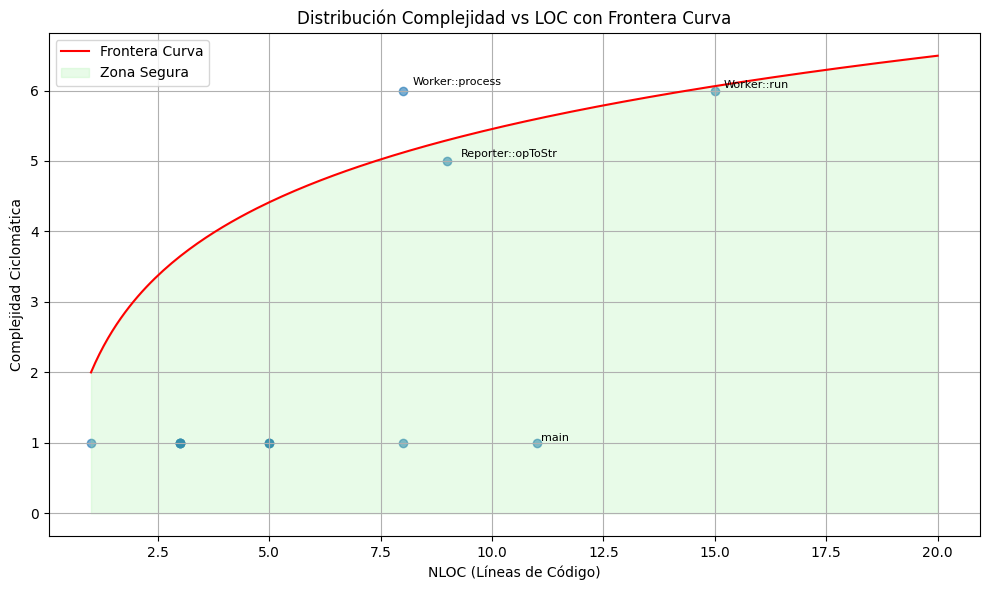

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Leer CSV
df = pd.read_csv(
    "../results/metrics.csv",
    names=[
        "nloc",
        "cyclomatic_complexity",
        "token_count",
        "parameters",
        "length",
        "function_info",
        "filename",
        "name",
        "long_name",
        "start_line",
        "end_line"
    ]
)

# Scatter base
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df["nloc"], df["cyclomatic_complexity"], alpha=0.6)
ax.set_xlabel("NLOC (Líneas de Código)")
ax.set_ylabel("Complejidad Ciclomática")
ax.set_title("Distribución Complejidad vs LOC con Frontera Curva")
ax.grid(True)

# Frontera curva
a = 2.0
b = 1.5
nloc_range = np.linspace(1, df["nloc"].max() + 5, 200)
complexity_limit = a + b * np.log(nloc_range)

ax.plot(nloc_range, complexity_limit, color='red', linestyle='-', label='Frontera Curva')
ax.fill_between(
    nloc_range, 0, complexity_limit,
    color='lightgreen', alpha=0.2, label='Zona Segura'
)

# Distancia a la frontera
df["complexity_over_limit"] = df["cyclomatic_complexity"] - (a + b * np.log(df["nloc"].clip(lower=1)))

# Puntos fuera de la frontera
df_risk = df[df["complexity_over_limit"] > 0]

# Puntos destacados dentro de la zona para contexto
df_top_loc = df.sort_values("nloc", ascending=False).head(3)
df_top_cyclomatic = df.sort_values("cyclomatic_complexity", ascending=False).head(3)

# Combinar y quitar duplicados
df_labels = pd.concat([df_risk, df_top_loc, df_top_cyclomatic]).drop_duplicates()

# Agregar etiquetas
texts = []
for _, row in df_labels.iterrows():
    texts.append(
        ax.text(row["nloc"], row["cyclomatic_complexity"], row["name"], fontsize=8)
    )

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# Crear tabla de funciones fuera del umbral
df_risk = df[df["complexity_over_limit"] > 0].copy()
df_risk = df_risk.sort_values("complexity_over_limit", ascending=False)

# Seleccionar columnas clave para el reporte
df_risk_report = df_risk[[
    "filename",
    "name",
    "nloc",
    "cyclomatic_complexity",
    "complexity_over_limit"
]]

# Renombrar columnas para mayor claridad
df_risk_report = df_risk_report.rename(columns={
    "filename": "Archivo",
    "name": "Función",
    "nloc": "LOC",
    "cyclomatic_complexity": "Complejidad",
    "complexity_over_limit": "Exceso"
})

# Mostrar tabla en Markdown
print("\n## Funciones fuera de la zona segura\n")
print(df_risk_report.to_markdown(index=False, floatfmt=".2f"))


## Funciones fuera de la zona segura

| Archivo                          | Función         |   LOC |   Complejidad |   Exceso |
|:---------------------------------|:----------------|------:|--------------:|---------:|
| ../../../apps/calcjob/Worker.hpp | Worker::process |     8 |             6 |     0.88 |
